# Testing Hemker & Maas (1987) multiaquifer transient drawdown solution

@TO 2023-03-15

Hemker and Maas solved the problem to analytically analyze transient drawdown due to well screens in a multi-aqufier radial flow system with storage both in the aqufiers and the aquitards. Maas used matrix function theory, while Hemker used linear algebra. The approaches yield the same result.

This document tests our implementation of their solution. The testing will be done by comparing to the examples in their article and by comparing with a numerical radial finite difference approch which should and does yield the same result.

TO 2023-03-14

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import hemkmaas87 as hm87
from fdm import fdm3t, Grid
import etc

clrs = ['b', 'r', 'g', 'k', 'm', 'c', 'y']

In [2]:
for k in hm87.cases:
    print('{:6s} {}'.format(k, hm87.cases[k]['name']))

Mine   My personal test
Hant1  Hantush using one layer
Hant2  Hantush using 2 layers
1A     Fig 1A
1B     Fig 1B
2A     One aquitard system Fig. 2 A
2A1    Three-aquitard system Fig. 2 A1
2A2    Three-aquitard system Fig. 2 A2
2B     Three-aquitard system Fig. 2 B
2C     Three-aquitard system Fig. 2 C
2D     Three-aquitard system Fig. 2 D
3      Hemker-Maas (1987) Fig. 3
4A     Hemker-Maas (1987) Fig. 4a
4B     Hemker-Maas (1987) Fig. 4b
4C     Hemker-Maas (1987) Fig. 4c


Turn case into a numerical radial model and run it.

In [3]:
key = '3'
kw = hm87.cases[key]
naquif = len(kw['kD'])
natard = len(kw[ 'c'])
nlay = naquif + natard
Iaq = np.arange(1, nlay, 2, dtype=int)
Iat = np.arange(0, nlay, 2, dtype=int)

rw = 0.25 # Well radius
ts = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
rs = np.hstack((0., rw, np.logspace(0, 6, 63)))
z = np.linspace(0., -nlay, nlay + 1)
D = np.abs(np.diff(z))

gr = Grid(rs, None, z, axial=True)

kh = np.zeros(gr.shape)
kv = np.zeros(gr.shape)
kh[Iaq, :, :] = (kw['kD'] / D[Iaq])[:, np.newaxis, np.newaxis]
kv[Iat, :, :] = (D[Iat] / kw[ 'c'])[:, np.newaxis, np.newaxis]

Ss = np.zeros(gr.shape)
Ss[Iaq, :, :] = (kw[ 'S'] / D[Iaq])[:, np.newaxis, np.newaxis]
Ss[Iat, :, :] = (kw['St'] / D[Iat])[:, np.newaxis, np.newaxis]

HI = np.zeros(gr.shape)
FQ = np.zeros(gr.shape); FQ[Iaq, 0, 0] = kw['Q']

# Consider the thickness of the top and bottom Layer
kv[[0, -1], :, :] /= 2.
kv[Iaq, :, :] = kh[Iaq, :, :] * 1e5

IBOUND = np.ones(gr.shape, dtype=int); IBOUND[[0, -1], : ,:] = -1

out = fdm3t.fdm3t(gr=gr, t=ts, kxyz=(kh, kh, kv), Ss=Ss,
          FQ=FQ, HI=HI, IBOUND=IBOUND)


Running in axial mode, y-values are ignored.


Then show it:

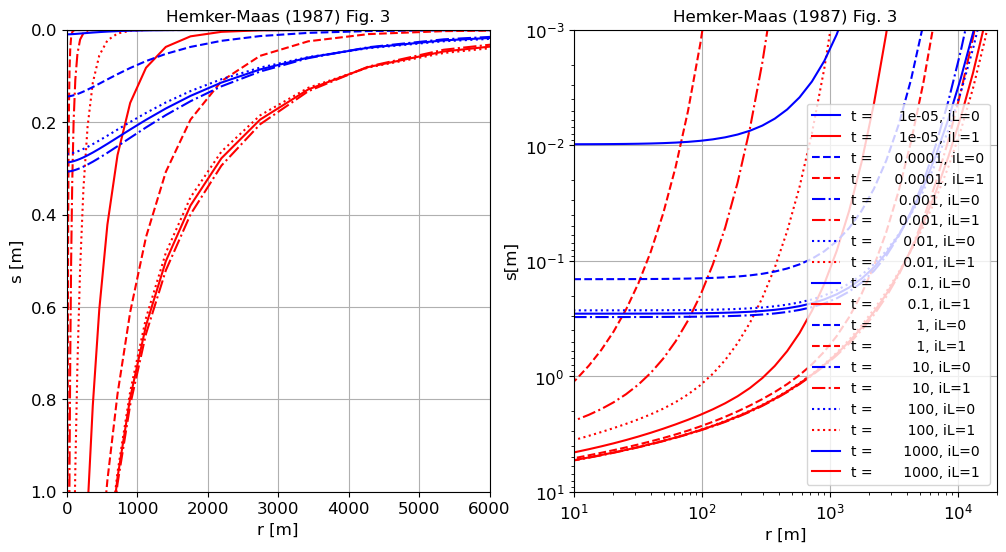

In [4]:
titles = kw['name'], kw['name']
xlabel, ylabels = 'r [m]', ('s [m]', 's [m]')
xlim = 1., 1.e4, ((1., 0.), (10., 1e-3))
axs = etc.newfigs2(titles,
                   xlabels=('r [m]', 'r [m]'),
                   ylabels=('s [m]', 's[m]'),
                   xlims=((0., 6000.), (10., 2e4)),
                   ylims=((1., 0.), (10., 1e-3)),
                   xscales=('linear', 'log'),
                   yscales=('linear', 'log'),
                   invert_yaxes=None,
                   figsize=(12, 6), fontsize=12)
lsc = etc.line_cycler()
for it, t in enumerate(ts):
    ls = next(lsc)
    csc = etc.color_cycler()    
    for ic, iL in enumerate(Iaq[:2]):  # range(gr.shape[0]):
        axs[0].plot(gr.xm, out['Phi'][it][iL][0],
                    color=clrs[ic], ls=ls, label='t = {:10.5g}, iL={}'.format(t, ic))
        axs[1].plot(gr.xm, out['Phi'][it][iL][0],
                    color=clrs[ic], ls=ls, label='t = {:10.5g}, iL={}'.format(t, ic))
axs[0].set_ylim(1.,   0.); axs[1].set_ylim(1.0e+1, 1.0e-3)
axs[0].set_xlim(0, 6000.); axs[1].set_xlim(1.0e+1, 2.0e+4)
axs[1].legend()

The picture above matches Fig. 3 in Hemker and Maas (1987).

Below the same picture generated analytically.

In [16]:
sout = {i:{'t': t} for i, t in enumerate(ts)}
for k in sout:
    print('t = {:.5g} d'.format(sout[k]['t']))
    sout[k]['s'] = hm87.solution(ts=sout[k]['t'], rs=rs[1:], **kw)
print('Done! See sout')

t = 1e-05 d
t = 0.0001 d
t = 0.001 d
t = 0.01 d
t = 0.1 d
t = 1 d
t = 10 d
t = 100 d
t = 1000 d
Done! See sout


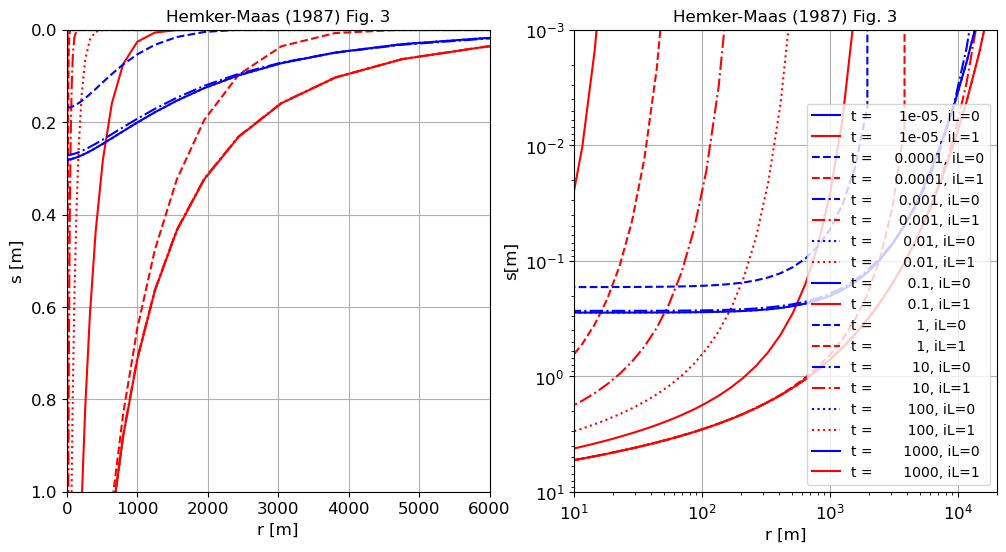

In [17]:
axs = etc.newfigs2(titles,
                   xlabels=('r [m]', 'r [m]'),
                   ylabels=('s [m]', 's[m]'),
                   xlims=((0., 6000.), (10., 2e4)),
                   ylims=((1., 0.), (10., 1e-3)),
                   xscales=('linear', 'log'),
                   yscales=('linear', 'log'),
                   invert_yaxes=None,
                   figsize=(12, 6), fontsize=12)
lsc = etc.line_cycler()
for k in sout:
    ls = next(lsc)
    csc = etc.color_cycler()    
    for iL in range(len(kw['kD'][:2])):  # range(gr.shape[0]):
        axs[0].plot(rs[1:], sout[k]['s'][iL],
                    color=clrs[iL], ls=ls, label='t = {:10.5g}, iL={}'.format(sout[k]['t'], iL))
        axs[1].plot(rs[1:], sout[k]['s'][iL],
                    color=clrs[iL], ls=ls, label='t = {:10.5g}, iL={}'.format(sout[k]['t'], iL))
axs[0].set_ylim(1.,   0.); axs[1].set_ylim(1.0e+1, 1.0e-3)
axs[0].set_xlim(0, 6000.); axs[1].set_xlim(1.0e+1, 2.0e+4)
axs[1].legend()


The curves above look like Hemker and Maas (1987) but not exactly. Also, it differs from the numerical soluiton above, which really is more close to Hemker and Maas (1987)

In [22]:
sout[8]

{'t': 1000,
 's': array([[2.80790623e-001, 2.80789997e-001, 2.80789648e-001,
         2.80789120e-001, 2.80788323e-001, 2.80787121e-001,
         2.80785310e-001, 2.80782584e-001, 2.80778488e-001,
         2.80772342e-001, 2.80763136e-001, 2.80749372e-001,
         2.80728832e-001, 2.80698247e-001, 2.80652812e-001,
         2.80585492e-001, 2.80486035e-001, 2.80339568e-001,
         2.80124649e-001, 2.79810560e-001, 2.79353638e-001,
         2.78692383e-001, 2.77741110e-001, 2.76381987e-001,
         2.74455530e-001, 2.71750095e-001, 2.67991676e-001,
         2.62836647e-001, 2.55871863e-001, 2.46628761e-001,
         2.34620123e-001, 2.19408580e-001, 2.00712507e-001,
         1.78544597e-001, 1.53359142e-001, 1.26158109e-001,
         9.84844767e-002, 7.22354821e-002, 4.92822504e-002,
         3.09889957e-002, 1.78354735e-002, 9.35814481e-003,
         4.46376102e-003, 1.92036129e-003, 7.28782565e-004,
         2.33913733e-004, 5.97996730e-005, 1.13227863e-005,
         1.45990906e-00